J'ai transposé le TP qu'on a fait en R en un notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kernels
from sklearn.decomposition import PCA

In [2]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

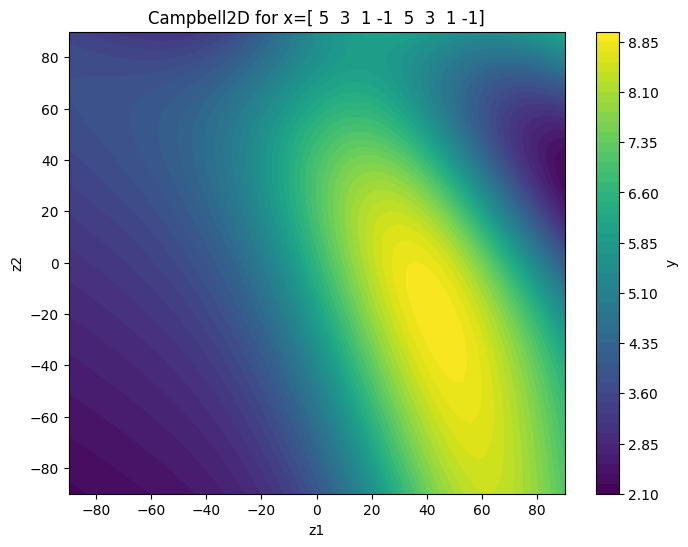

In [3]:
n_grid = 64
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [4]:
n_test=1000

x=np.random.uniform(-1,5,(n_test,8)) #on simule les données d'entrée avec une loi uniforme

y = np.zeros((n_test,n_grid*n_grid))  # matrice (1000, 4096)
for i in range(n_test):
    yi = Simulateur(x[i], Z1, Z2)
    y[i,:]=yi.flatten()  # on aplati la carte 64x64 pour pouvoir faire l'ACP

print("Forme de y :",y.shape)

Forme de y : (1000, 4096)


In [5]:
n_PC = 5
pca = PCA(n_components=n_PC)
Y_pca = pca.fit_transform(Y)

print("Variance expliquée par les 5 premières composantes :",pca.explained_variance_ratio_)

Variance expliquée par les 5 premières composantes : [7.79517093e-01 2.14303132e-01 5.42328074e-03 7.08358715e-04
 4.11232554e-05]


Ensuite il faut utiliser les processus gaussiens pour construire le métamodèle -> A CONTINUER!